<a href="https://colab.research.google.com/github/IrisFDTD/PINNs-for-education/blob/main/PINN_for_optics_eikonal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Utilizing Physical Informed Neural Networks (PINN) for solving eikonal-based Ordinary Differential Equations

+ This notebook has been implemented by Andrés Martínez Esteban <787148@unizar.es> and Sergio Gutiérrez Rodrigo <sergut@unizar.es> as part of a Final Degree Thesis at the University of Zaragoza, 2023.
+ The code builds upon the 2nd-order ODE implementation using Physics-Informed Neural Networks (PINNs) done by Luis Medrano Navarro, Luis Martin Moreno and Sergio G Rodrigo ([Solving differential equations in physics with Deep Learning: a beginner’s guide](https://arxiv.org/abs/2307.11237)).

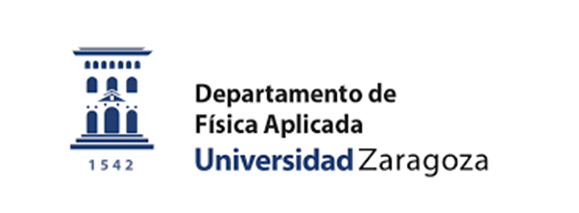

# Definition of the problem

Comentarios:
+ Es un lío la comparación entre PINNs y RK. Por ejemplo, la definición de A es diferente a la de GM_c2 aunque valen lo mismo!!
+ Otro lío son las condiciones de contorno. Parecen diferentes en los dos métodos, y no tendrían que serlo.

## Eikonal

The Eikonal equation:

\begin{equation}
    \frac{d}{ds}\left(n\frac{d\mathbf{r}}{ds}\right)=\nabla n
\end{equation}

with vector notation $\mathbf{r}=(x,y,z)$. The left-hand side of this equation represents the curvature of the ray, while on the other side, we find the gradient of the refractive index. As a result, the ray will always bend towards regions of maximum gradient. If we consider an isotropic medium, the right-hand side would be zero since $n$ would not depend on spatial directions. This is why the trajectories are straight lines.

## Black-hole model based on light ray equation

For a GRIN medium, particularly an optical fiber, it is consider a quadratic refractive index

\begin{equation}
    n^2(x,y)=n_o^2\left(1-g^2(x^2+y^2)\right)
\end{equation}

where $g$ is a real constant characteristic of the medium, and $n_o$ is the refractive index along the axis of symmetry $z$. It can be observed how $n(x,y)$ decreases as we move radially away from this axis. We will mainly solve two cases: one that leads to an ordinary differential equation and the latter to two coupled differential equations.

We can approximate using the Taylor series expansion. We obtain:

$$n(x, y) =\frac{1}{1-\frac{2GM}{c^2r}}$$


Now, we are not going to make this approximation, so we need to obtain the gradient from the first expression (which can be analytically derived by performing the calculations). Finally, considering the second approximation and the equation:

$$\frac{d}{ds}\left(n\frac{dr}{ds}\right) = \nabla n$$

where $r = (x(s), y(s))$. The equations to solve are as follows:

$$\frac{dx}{ds}=\frac{v_x}{n}$$

$$\frac{dy}{ds}=\frac{v_y}{n}$$

$$\frac{dv_x}{ds}=-n^2\frac{2GM}{c^2}\frac{x}{r^3}$$

$$\frac{dv_y}{ds}=-n^2\frac{2GM}{c^2}\frac{y}{r^3}$$



# Important libraries

In [1]:
import tensorflow as tf

print("Versión de TensorFlow:", tf.__version__)


Versión de TensorFlow: 2.15.0


In [1]:
## Tensorflow Keras and rest of the packages
import keras as k
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
#import tensorflow.keras as k2
from keras.layers import Dense,Input
from keras.optimizers import Adam, RMSprop
from keras.models import load_model, save_model
from keras.saving import register_keras_serializable
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import cmath
import math
from tensorflow import keras
import time
import pandas as pd

# Auxiliary functions

In [2]:
def plot_history_by_key(keys):
  import matplotlib.pyplot as plt
  for key in keys:
    plt.plot(history.history[key],marker='o',markersize=0.0, linewidth=1.0,label=key)
  plt.xlabel('epoch')
  plt.legend()
  plt.show()
  return history.history[key]

# Stop at certain loss


In [3]:
class StopTrainingOnLoss(tf.keras.callbacks.Callback):
    def __init__(self, target_loss):
        super(StopTrainingOnLoss, self).__init__()
        self.target_loss = target_loss


    def on_epoch_end(self, epoch, logs=None):
        current_loss = logs.get('loss')
        if current_loss is not None and current_loss <= self.target_loss:
            print(f"\nReached target loss of {self.target_loss}. Stopping training.")
            self.model.stop_training = True

# We define the radius (r) and the refractive index (n).

In [4]:
def r (x,y):
  return (tf.sqrt(x**2+y**2))

def n_ind(x,y,A):
  return (1.0/(1.0-A/r(x,y)))

# Definition of the PINN

In [5]:
@register_keras_serializable()
@keras.saving.register_keras_serializable()
class ODE_2nd(tf.keras.Model):
    def set_ODE_param(self,z0,x0,dx_dz0,A, auxx, aux2):
        '''
        Set parameters and initial conditions for the ODE
        '''
        self.z0=tf.constant([z0], dtype=tf.float32)
        self.x0_true=tf.constant(x0, dtype=tf.float32)
        self.dx_dz0_true=tf.constant(dx_dz0, dtype=tf.float32)
        self.A=tf.constant(A,dtype=tf.float32)
        self.auxx=tf.constant(auxx,dtype=tf.float32)
        self.aux2=tf.constant(aux2,dtype=tf.float32)

    def train_step(self, data):
        '''
        Training ocurrs here
        '''
        z, x_true = data
        with tf.GradientTape() as tape:
            #* Initial conditions
            tape.watch(self.z0)
            tape.watch(self.x0_true)
            tape.watch(self.dx_dz0_true)
            tape.watch(self.A)
            tape.watch(z)

            with tf.GradientTape() as tape0:
                    tape0.watch(self.z0)
                    x0_pred= self(self.z0,training=False)
                    tape0.watch(x0_pred)

            with tf.GradientTape() as tape1:
                tape1.watch(z)
                x=self(z,training=False)
                tape1.watch(x)
            dx_dz=tape1.jacobian(x,z)
            dx_dz=tf.squeeze(dx_dz)
            dx_dz=tf.reshape(dx_dz,shape=x.shape)
            tape.watch(z)
            tape.watch(x)
            tape.watch(dx_dz)

 
            #* Definition of r and n
            r=tf.math.sqrt(x[:,0]**2+x[:,1]**2)
            n=1.0/(1.0-self.A/r)
            aux=[0.0,0.0,0.0,0.0]
            aux=tf.reshape(aux,shape=x.shape)
  

            #? Original ODE's order
            '''
            lossODE= self.compiled_loss(dx_dz[:,0],x[:,2]/n)\
                    +self.compiled_loss(dx_dz[:,1],x[:,3]/n)\
                    +self.compiled_loss(dx_dz[:,2],-self.A*tf.math.pow(n,2)*x[:,0]/tf.math.pow(r,3))\
                    +self.compiled_loss(dx_dz[:,3],-self.A*tf.math.pow(n,2)*x[:,1]/tf.math.pow(r,3))

            '''
            '''
            #? Alternative ODE's order (1)
            lossODE= self.compiled_loss(n*dx_dz[:,0],x[:,2])\
                    +self.compiled_loss(n*dx_dz[:,1],x[:,3])\
                    +self.compiled_loss(tf.math.pow(r,3)*dx_dz[:,2]/tf.math.pow(n,2),-self.A*x[:,0])\
                    +self.compiled_loss(tf.math.pow(r,3)*dx_dz[:,3]/tf.math.pow(n,2),-self.A*x[:,1])
                    #+self.compiled_loss(A/tf.math.pow((x[:,0]*x[:,0]+x[:,1]*x[:,1]),0.5),aux[:,0])

            '''
            
            #? Alternative ODE's order (2)
            lossODE= self.compiled_loss(dx_dz[:,0],x[:,2]/n)\
                    +self.compiled_loss(dx_dz[:,1],x[:,3]/n)\
                    +self.compiled_loss(tf.math.pow(r,3)*dx_dz[:,2],-self.A*tf.math.pow(n,2)*x[:,0])*5\
                    +self.compiled_loss(tf.math.pow(r,3)*dx_dz[:,3],-self.A*tf.math.pow(n,2)*x[:,1])*10
                


            #* initial condition loss
            lossODE= lossODE\
                  + self.compiled_loss(x0_pred,self.x0_true) \
                  
            #* "Chinchetas" loss
            aux_pred=self(self.aux2, training=False)
            loss=lossODE\
                +self.compiled_loss(self.auxx,aux_pred)*5


        gradients = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_weights))
        self.compiled_metrics.update_state(x_true, x)
        metrics={m.name: m.result() for m in self.metrics}
        metrics.pop('mean_squared_error')
        metrics['z']=z
        metrics['x0']=x0_pred[:,0]
        metrics['y0']=x0_pred[:,1]
        metrics['vx0']=x0_pred[:,2]
        metrics['vy0']=x0_pred[:,3]
        metrics['x']=x[:,0]
        metrics['y']=x[:,1]
        metrics['vx']=x[:,2]
        metrics['vy']=x[:,3]
        metrics['n'] = n
        metrics['r'] = r
        print(self.A)
        return metrics

+ Problem's coordinates
$$A=2GM/c^2$$
$$n(x, y) =\frac{1}{1-\frac{A}{r}}$$

$$\frac{dx}{ds}=\frac{v_x}{n}$$

$$\frac{dy}{ds}=\frac{v_y}{n}$$

$$\frac{dv_x}{ds}=-n^2\frac{2GM}{c^2}\frac{x}{r^3}$$

$$\frac{dv_y}{ds}=-n^2\frac{2GM}{c^2}\frac{y}{r^3}$$

+ PINN's coordinates
$$\vec x=(x_0,x_1,x_2,x_3)=(x,y,v_x,v_y)$$
(Escribir...)


# Common parameters

In [6]:
A=8.0/100        #it represents the factor 2GM/c^2
GM_c2= A/2   #it represents the factor GM/c^2
x0_rk = -1; x_ini= -1
y0_rk = 0.35; y_ini=0.35
vx0_rk=1/(1.0/(1.0-A/np.sqrt(x0_rk**2+y0_rk**2)))   ; vx_ini=1/(1.0/(1.0-A/np.sqrt(x0_rk**2+y0_rk**2)))
vy0_rk = 0.0  ; vy_ini=0.0


## RK definitions

In [7]:

def f_x(t, x, y, vx, vy):
    #* vx's ODE
    return vx/n_xy(x,y)

def f_y(t, x, y, vx, vy):
    #* vy's ODE
    return vy/n_xy(x, y)

def g_x(t, x, y, vx, vy):
    #* ax's ODE
    return -n_xy(x,y)**2*2*GM_c2*x/((x**2+y**2+epsilon2**2)**(3/2))

def g_y(t, x, y, vx, vy):
    #* ay's ODE
    return -n_xy(x,y)**2*2*GM_c2*y/((x**2+y**2+epsilon2**2)**(3/2))

def n_xy(x, y):
    #*Ecuación que calcula el índice de refracción
    return (1/(1-(2*GM_c2/(x**2+y**2+epsilon2**2)**0.5)))

#* fourth order runge kutta
def runge_kutta_4th_order(t, x, y, vx, vy, h):

    k1_x = h * f_x(t, x, y, vx, vy)
    k1_y = h * f_y(t, x, y, vx, vy)
    k1_vx = h * g_x(t, x, y, vx, vy)
    k1_vy = h * g_y(t, x, y, vx, vy)

    k2_x = h * f_x(t + 0.5 * h, x + 0.5 * k1_x, y + 0.5 * k1_y, vx + 0.5 * k1_vx, vy + 0.5 * k1_vy)
    k2_y = h * f_y(t + 0.5 * h, x + 0.5 * k1_x, y + 0.5 * k1_y, vx + 0.5 * k1_vx, vy + 0.5 * k1_vy)
    k2_vx = h * g_x(t + 0.5 * h, x + 0.5 * k1_x, y + 0.5 * k1_y, vx + 0.5 * k1_vx, vy + 0.5 * k1_vy)
    k2_vy = h * g_y(t + 0.5 * h, x + 0.5 * k1_x, y + 0.5 * k1_y, vx + 0.5 * k1_vx, vy + 0.5 * k1_vy)

    k3_x = h * f_x(t + 0.5 * h, x + 0.5 * k2_x, y + 0.5 * k2_y, vx + 0.5 * k2_vx, vy + 0.5 * k2_vy)
    k3_y = h * f_y(t + 0.5 * h, x + 0.5 * k2_x, y + 0.5 * k2_y, vx + 0.5 * k2_vx, vy + 0.5 * k2_vy)
    k3_vx = h * g_x(t + 0.5 * h, x + 0.5 * k2_x, y + 0.5 * k2_y, vx + 0.5 * k2_vx, vy + 0.5 * k2_vy)
    k3_vy = h * g_y(t + 0.5 * h, x + 0.5 * k2_x, y + 0.5 * k2_y, vx + 0.5 * k2_vx, vy + 0.5 * k2_vy)

    k4_x = h * f_x(t + h, x + k3_x, y + k3_y, vx + k3_vx, vy + k3_vy)
    k4_y = h * f_y(t + h, x + k3_x, y + k3_y, vx + k3_vx, vy + k3_vy)
    k4_vx = h * g_x(t + h, x + k3_x, y + k3_y, vx + k3_vx, vy + k3_vy)
    k4_vy = h * g_y(t + h, x + k3_x, y + k3_y, vx + k3_vx, vy + k3_vy)

    new_x = x + (1/6) * (k1_x + 2 * k2_x + 2 * k3_x + k4_x)
    new_y = y + (1/6) * (k1_y + 2 * k2_y + 2 * k3_y + k4_y)
    new_vx = vx + (1/6) * (k1_vx + 2 * k2_vx + 2 * k3_vx + k4_vx)
    new_vy = vy + (1/6) * (k1_vy + 2 * k2_vy + 2 * k3_vy + k4_vy)

    return new_x, new_y, new_vx, new_vy

## Run RK

In [8]:
#* RK's initial conditions

t0 = 0.0
tfin=2
h = 0.01  # time step
pasos= int((tfin-t0)/h)
epsilon=0.1
epsilon2=0

x_tot=[]
y_tot=[]
vx_tot=[]
vy_tot=[]
t_tot=[]

x_tot.append(x0_rk)
y_tot.append(y0_rk)
vx_tot.append(vx0_rk)
vy_tot.append(vy0_rk)
t_tot.append(t0)


x_rk=x0_rk; y_rk=y0_rk; vx_rk=vx0_rk; vy_rk=vy0_rk
for i in range(pasos):
    x_rk, y_rk, vx_rk, vy_rk = runge_kutta_4th_order(t0, x_rk, y_rk, vx_rk, vy_rk, h)
    if (((x_rk**2+y_rk**2)**0.5)<A+0.001):

        break
    x_tot.append(x_rk)
    y_tot.append(y_rk)
    vx_tot.append(vx_rk)
    vy_tot.append(vy_rk)
    t0 += h
    t_tot.append(t0)


# Define the PINN

In [10]:
#* Initial conditions NN
n_ini=n_ind(x_ini, y_ini,A).numpy()
x0=[x_ini,y_ini,vx_ini,vy_ini]
dx_dz0=[vx_ini/n_ini,
        vy_ini/n_ini,
        -n_ini**2*A*x_ini/(r(x_ini,y_ini).numpy())**3,
        -n_ini**2*A*y_ini/(r(x_ini,y_ini).numpy())**3]
print("n(0)=",n_ini)
print('x(0)=',x0)
print('dx_dz(0)=',dx_dz0)




N_train_max =200
zmax = 2
N_intervalos=5
salto=int(N_train_max/N_intervalos)
salto_z=zmax/N_intervalos
norm=N_train_max
repeats=10

stop_on_loss_callback = StopTrainingOnLoss(target_loss=0.000005)


N_train=0
zmed=0
z0 = 0
auxx=[]
aux2=[]




#* Input and output neurons (from the data)
input_neurons  = 1
output_neurons = 4

#* Hiperparameters
batch_size = 1
epochs = 8000



#* Stops after certain epochs without improving and safe the best weight
#! If the simulation ends normally instead of by this callback, the program will take last weights not best
callbacks = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=1000,
                                            restore_best_weights=True)
for sim in range (5, repeats):
    for chinch in range (N_intervalos):

        checkpoint_callback = ModelCheckpoint(filepath=f'modelos_agujero_negro/pesos_inter={N_intervalos}_y={y_ini}_N={N_train_max}_sim={sim}.h5', 
                                      monitor='loss', 
                                      save_best_only=True, 
                                      save_weights_only=True, 
                                      mode='min',
                                      verbose=1)

        #* Define the model
        initializer = tf.keras.initializers.GlorotUniform(seed=5)
        activation='tanh'
        input=Input(shape=(input_neurons,))
        x=Dense(500, activation=activation,kernel_initializer=initializer)(input)
        x=Dense(500, activation=activation,kernel_initializer=initializer)(x)
        x=Dense(500, activation=activation,kernel_initializer=initializer)(x)
        x=Dense(500, activation=activation,kernel_initializer=initializer)(x)
        x=Dense(500, activation=activation,kernel_initializer=initializer)(x)
        output = Dense(output_neurons,kernel_initializer=initializer,activation=None)(x)

        #* Build the model
        model=ODE_2nd(input,output)

        #*Define the metrics, optimizer and loss
        loss= tf.keras.losses.MeanSquaredError()
        metrics=tf.keras.metrics.MeanSquaredError()
        optimizer= Adam(learning_rate=0.00005)


        model.compile(loss=loss,
            optimizer=optimizer,
            metrics=metrics,
            run_eagerly=False)
        model.summary() 

        N_train=N_train+salto
        zmed=zmed+salto_z

        z_train=np.linspace(z0,zmed,N_train)
        z_train=np.reshape(z_train,(N_train,1))
        y_train=np.zeros((z_train.shape[0],1))

        #* Set ODE parameters and initial conditions
        model.set_ODE_param(z0=[z0],x0=x0,dx_dz0=dx_dz0,A=A, auxx=auxx, aux2=aux2)

        if(chinch==(N_intervalos-1)):
            history=model.fit(z_train, y_train, batch_size=1, epochs=4000,verbose=1,
                        callbacks=checkpoint_callback) #,shuffle=False)
            model.load_weights(f"modelos_agujero_negro/pesos_inter={N_intervalos}_y={y_ini}_N=200_sim={sim}.h5")
            xy_pred=model.predict(z_train)

            
        else:               
            #history=model.fit(z_train, y_train, batch_size=1, epochs=epochs,verbose=1,
                        #callbacks=[callbacks, stop_on_loss_callback]) #,shuffle=False)
            history=model.fit(z_train, y_train, batch_size=1, epochs=epochs,verbose=1,
                        callbacks=[checkpoint_callback,callbacks]) #,shuffle=False)
            model.load_weights(f"modelos_agujero_negro/pesos_inter={N_intervalos}_y={y_ini}_N=200_sim={sim}.h5")
            xy_pred=model.predict(z_train)
            
        auxx.append(xy_pred[N_train-1])
        aux2.append(z_train[N_train-1])
    
    z_red=z_train
    #model.load_weights(f"modelos_agujero_negro/pesos_inter={N_intervalos}_y={y_ini}_N=200_sim={sim}.h5")
    xy_pred=model.predict(z_red)

    error=0
    diff_inter=int(pasos/N_train_max)

    for k in range (N_train_max-2):
        error=error+(x_tot[k*diff_inter]-xy_pred[k,0])**2
        error=error+(y_tot[k*diff_inter]-xy_pred[k,1])**2
        error=error+(vx_tot[k*diff_inter]-xy_pred[k,2])**2
        error=error+(vy_tot[k*diff_inter]-xy_pred[k,3])**2

    print(f"n chinchetas={N_intervalos-1} error={error}")

    #* We save the PINN data trajectories
    ruta_error = f'multiple_agujero_negro/error_chinchetas_y{y_ini}.txt'

    with open(ruta_error, 'a') as archivo:
        archivo.write(f'{N_intervalos-1}\t{sim}\t{error}\n')

    chincheta_aux=[]
    chinchetas=np.array(auxx)
    for l in aux2:
        chincheta_aux.append(l[0])
    
    #* We save the PINN data trajectories
    ruta_chinchetas = f'multiple_agujero_negro/chinchetas_y0={y_ini}_Ninter={N_intervalos}_rep={sim}.txt'

    with open(ruta_chinchetas, 'w') as archivo:
        for valor1, valor2, valor3, valor4, valor5 in zip(chincheta_aux, chinchetas[:,0], chinchetas[:,1], chinchetas[:,2], chinchetas[:,3]):
            archivo.write(f'{valor1}\t{valor2}\t{valor3}\t{valor4}\t{valor5}\n')
    N_train=0
    zmed=0
    auxx=[]
    aux2=[]
    

n(0)= 1.0816759
x(0)= [-1, 0.35, 0.9244913314907185, 0.0]
dx_dz(0)= [0.8546842381432707, 0.0, 0.07870543709401108, -0.027546902982903874]
Model: "ode_2nd_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense_6 (Dense)             (None, 500)               1000      
                                                                 
 dense_7 (Dense)             (None, 500)               250500    
                                                                 
 dense_8 (Dense)             (None, 500)               250500    
                                                                 
 dense_9 (Dense)             (None, 500)               250500    
                                                                 
 dense_10 (Dense)            (None, 500)           

KeyboardInterrupt: 

# Plot loss vs (last) epochs

In [ ]:
#* summarize history for loss
plt.plot(np.log10(history.history['loss']),marker='o',markersize=0.0, linewidth=1)
plt.xlabel('época',fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.legend(['función coste'], loc='upper left')
plt.show()

In [24]:
z_red=z_train
model.load_weights(f"modelos_agujero_negro/pesos_inter={N_intervalos}_y={y_ini}_N=200_sim=11.h5")
#? Use if you are going to plot some save model
#z_red=np.linspace(zmin,zmax,40)
#z_red=np.reshape(z_red,(200,1))
xy_pred=model.predict(z_red)

7/7 [==============================] - 0s 2ms/step


# Save files


In [16]:
#ruta_archivo_save = 'modelos_agujero_negro/y=0_90n=400 chinchetas.keras'

#save_model(model, ruta_archivo_save)

In [ ]:
#ruta_archivo_load = 'modelos_agujero_negro/y=0_90n=400 chinchetas.keras'

#model=load_model(ruta_archivo_load)

# Escribir fichero


In [ ]:

#* We save the PINN data trajectories
#ruta_archivo_p = 'multiple_agujero_negro/y={y0}p.txt'

with open(ruta_archivo_p, 'w') as archivo:
    for valor1, valor2 in zip(xy_pred[:,0], xy_pred[:,1]):
        archivo.write(f'{valor1}\t{valor2}\n')


In [ ]:
#* We keep the runge-kutta data trajectories
#ruta_archivo_t = 'multiple_agujero_negro/y={y0}t.txt'


with open(ruta_archivo_t, 'w') as archivo:
    for valor1, valor2 in zip(x_tot, y_tot):
        archivo.write(f'{valor1}\t{valor2}\n')


In [ ]:
#* We keep the runge-kutta data trajectories
#ruta_archivo_c = 'multiple_agujero_negro/{y0}c.txt'
chinchetas=np.array(auxx)

with open(ruta_archivo_c, 'w') as archivo:
    for valor1, valor2 in zip(chinchetas[:,0], chinchetas[:,1]):
        archivo.write(f'{valor1}\t{valor2}\n')

# Multiple rays plot

In [1]:


y0_07xp=[]
y0_07yp=[]
y0_07xt=[]
y0_07yt=[]
y0_06xp=[]
y0_06yp=[]
y0_06xt=[]
y0_06yt=[]
y0_05xp=[]
y0_05yp=[]
y0_05xt=[]
y0_05yt=[]
y0_45xp=[]
y0_45yp=[]
y0_45xt=[]
y0_45yt=[]
y0_04xp=[]
y0_04yp=[]
y0_04xt=[]
y0_04yt=[]
y0_03xp=[]
y0_03yp=[]
y0_03xt=[]
y0_03yt=[]


ruta1 = 'multiple_agujero_negro/y=0.70p.txt'
with open(ruta1, 'r') as archivo:
    for linea in archivo:

        valores = linea.split()

        y0_07xp.append(float(valores[0]))
        y0_07yp.append(float(valores[1]))

ruta2 = 'multiple_agujero_negro/y=0.70t.txt'
with open(ruta2, 'r') as archivo:
    for linea in archivo:

        valores = linea.split()

        y0_07xt.append(float(valores[0]))
        y0_07yt.append(float(valores[1]))

ruta3 = 'multiple_agujero_negro/y=0.60p.txt'
with open(ruta3, 'r') as archivo:

    for linea in archivo:

        valores = linea.split()

        y0_06xp.append(float(valores[0]))
        y0_06yp.append(float(valores[1]))

ruta4 = 'multiple_agujero_negro/y=0.60t.txt'
with open(ruta4, 'r') as archivo:

    for linea in archivo:

        valores = linea.split()

        y0_06xt.append(float(valores[0]))
        y0_06yt.append(float(valores[1]))


ruta5 = 'multiple_agujero_negro/y=0.50p.txt'
with open(ruta5, 'r') as archivo:

    for linea in archivo:

        valores = linea.split()

        y0_05xp.append(float(valores[0]))
        y0_05yp.append(float(valores[1]))

ruta6 = 'multiple_agujero_negro/y=0.50t.txt'
with open(ruta6, 'r') as archivo:

    for linea in archivo:

        valores = linea.split()

        y0_05xt.append(float(valores[0]))
        y0_05yt.append(float(valores[1]))

ruta7 = 'multiple_agujero_negro/y=0.45t.txt'
with open(ruta7, 'r') as archivo:

    for linea in archivo:

        valores = linea.split()

        y0_45xt.append(float(valores[0]))
        y0_45yt.append(float(valores[1]))

ruta8 = 'multiple_agujero_negro/y=0.45p.txt'
with open(ruta8, 'r') as archivo:

    for linea in archivo:

        valores = linea.split()

        y0_45xp.append(float(valores[0]))
        y0_45yp.append(float(valores[1]))


ruta9 = 'multiple_agujero_negro/y=0.40p.txt'
with open(ruta9, 'r') as archivo:

    for linea in archivo:

        valores = linea.split()

        y0_04xp.append(float(valores[0]))
        y0_04yp.append(float(valores[1]))

ruta10 = 'multiple_agujero_negro/y=0.40t.txt'
with open(ruta10, 'r') as archivo:

    for linea in archivo:

        valores = linea.split()

        y0_04xt.append(float(valores[0]))
        y0_04yt.append(float(valores[1]))



fig, ax = plt.subplots(dpi=150)
#* RK vs PINN
ax.plot(y0_07xt, y0_07yt, linestyle='-', linewidth=0.5,color='b', label='RK')
ax.plot(y0_07xp,y0_07yp, color="red",marker='o',markersize=1, linestyle='solid', linewidth=0.5, label="PINN")

ax.plot(y0_06xt, y0_06yt, linestyle='-', linewidth=0.5,color='b')
ax.plot(y0_06xp,y0_06yp, color="red",marker='o',markersize=1, linestyle='solid', linewidth=0.5)

ax.plot(y0_05xt, y0_05yt, linestyle='-', linewidth=0.5,color='b')
ax.plot(y0_05xp,y0_05yp, color="red",marker='o',markersize=1, linestyle='solid', linewidth=0.5)

ax.plot(y0_45xt, y0_45yt, linestyle='-', linewidth=0.5,color='b')
ax.plot(y0_45xp,y0_45yp, color="red",marker='o',markersize=1, linestyle='solid', linewidth=0)

ax.plot(y0_04xt, y0_04yt, linestyle='-', linewidth=0.5,color='b')
ax.plot(y0_04xp,y0_04yp, color="red",marker='o',markersize=1, linestyle='solid', linewidth=0.5)

#* We create the horizon event circle
circle = Circle((0, 0), A, fill=False, color='black', linestyle='-')
ax.add_patch(circle)

ax.set_xlabel('X (3·$10^8$ m)')
ax.set_ylabel('Y (3·$10^8$ m)')


#* Adds a legend
ax.legend()

plt.gca().set_aspect('equal', adjustable='box')

plt.grid(True)  # Optional
#plt.xlim(-100,-88)
#plt.ylim(48,51)

plt.legend(loc='upper right', bbox_to_anchor=(1.0, 1.2))

plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=2,fontsize=12)

plt.show()



FileNotFoundError: [Errno 2] No such file or directory: 'multiple_agujero_negro/y=0.70p.txt'

from google.colab import drive



# Plot the results

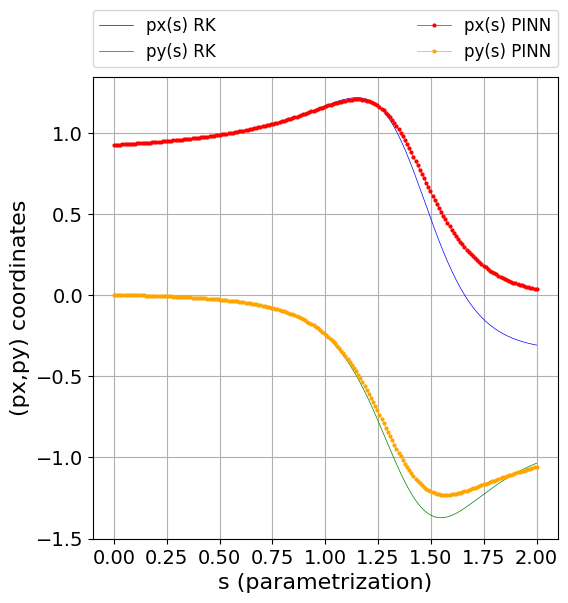

In [25]:
chinchetas=np.array(auxx)

fig, ax = plt.subplots(dpi=100)
#* RK
ax.plot(t_tot, vx_tot, linestyle='-', linewidth=0.5,color='b', label='px(s) RK')
ax.plot(t_tot, vy_tot, linestyle='-', linewidth=0.5,color='g', label='py(s) RK')

#* PINN
ax.plot(z_red, xy_pred[:,2], color="red",marker='o',markersize=2.0, linestyle='solid', linewidth=0.5, label="px(s) PINN")
ax.plot(z_red, xy_pred[:,3], color="orange",marker='o',markersize=2.0, linestyle='solid', linewidth=0.5, label="py(s) PINN")

#*"Chinchetas"
#ax.plot(aux2, chinchetas[:,2], "o", markersize=6, color='blue', label='chinchetas px')
#ax.plot(aux2, chinchetas[:,3], "o", markersize=6, color='green', label='chinchetas py')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

ax.set_xlabel('s (parametrization)', fontsize=16)
ax.set_ylabel('(px,py) coordinates', fontsize=16)

#* Adds a legend
ax.legend()

#* Show grafic
#plt.gca().set_aspect('equal', adjustable='box')

plt.grid(True)  # Optional
#plt.xlim(0,60)
#plt.ylim(0,1.1)
plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=2,fontsize=12)

fig.set_size_inches(6,6)
#?Save the plot
#fig.savefig(f'Black_hole_velocity_chinchetas={N_intervalos}_y={y_ini}_N={N_train_max}_.png',bbox_inches='tight', dpi=600)

plt.show()

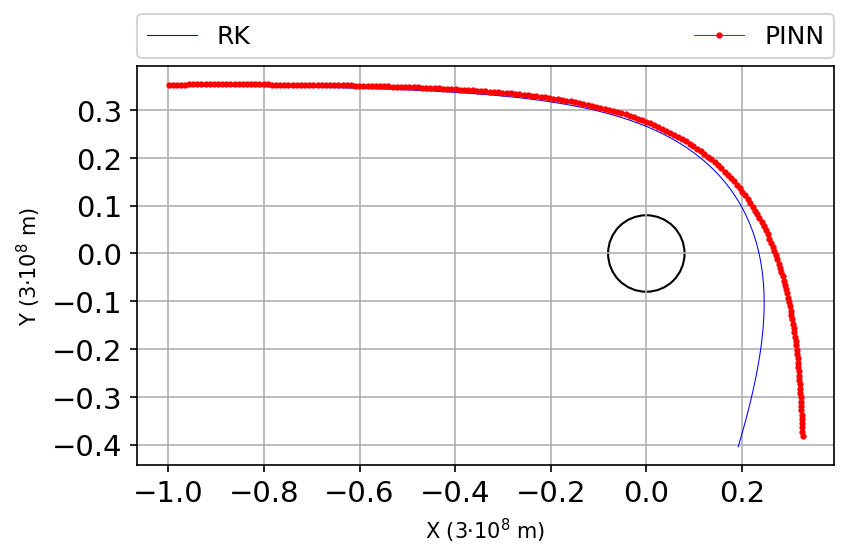

In [26]:
fig, ax = plt.subplots(dpi=150)
#* RK
ax.plot(x_tot, y_tot, linestyle='-', linewidth=0.5,color='b', label='RK')

#* Chinchetas
#ax.plot(chinchetas[:,0], chinchetas[:,1], "o", markersize=5, color='blue', label='RK')

#* PINN
ax.plot(xy_pred[:,0], xy_pred[:,1], color="red",marker='o',markersize=2.0, linestyle='solid', linewidth=0.5, label="PINN")

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

#* Adds the horizont event circle
circle = Circle((0, 0), A, fill=False, color='black', linestyle='-')
#circle = Circle((0, 0), A*3*10**8, fill=False, color='black', linestyle='-')
ax.add_patch(circle)

ax.set_xlabel('X (3·$10^8$ m)')
ax.set_ylabel('Y (3·$10^8$ m)')

#* Add legend
ax.legend()

#* Show grafic
plt.gca().set_aspect('equal', adjustable='box')

plt.grid(True)  # Optional
#plt.xlim(-100,-88)
#plt.ylim(48,51)

plt.legend(loc='upper right', bbox_to_anchor=(1.0, 1.2))

plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=2,fontsize=12)

fig.set_size_inches(6,6)
#? Save the plot
#plt.savefig(f'Black_hole_trajectorie_chinchetas={N_intervalos}_y={y_ini}_N={N_train_max}_.png',bbox_inches='tight', dpi=600)
plt.show()

# Error cometido

In [27]:
error=0

diff_inter=int(pasos/N_train_max)

for i in range (N_train_max):
    error=error+(x_tot[i*diff_inter]-xy_pred[i,0])**2
    error=error+(y_tot[i*diff_inter]-xy_pred[i,1])**2
    error=error+(vx_tot[i*diff_inter]-xy_pred[i,2])**2
    error=error+(vy_tot[i*diff_inter]-xy_pred[i,3])**2

print(f"n chinchetas={N_intervalos-1} error={error}")

n chinchetas=0 error=5.47855310994707


In [ ]:
#* We save the PINN data trajectories
ruta_error = f'multiple_agujero_negro/error_chinchetas_y{y_ini}.txt'

with open(ruta_error, 'a') as archivo:
    archivo.write(f'{N_intervalos-1}\t{error}\n')

# Guardar chinchetas

In [ ]:
chincheta_aux=[]
for i in aux2:
    chincheta_aux.append(i[0])
print(chincheta_aux)

In [ ]:
#* We save the PINN data trajectories
ruta_chinchetas = f'multiple_agujero_negro/chinchetas_y0={y_ini}_Ninter={N_intervalos}.txt'

with open(ruta_chinchetas, 'w') as archivo:
    for valor1, valor2, valor3, valor4, valor5 in zip(chincheta_aux, chinchetas[:,0], chinchetas[:,1], chinchetas[:,2], chinchetas[:,3]):
        archivo.write(f'{valor1}\t{valor2}\t{valor3}\t{valor4}\t{valor5}\n')

# Plot error

In [ ]:

ruta_error_045 = 'multiple_agujero_negro/error_chinchetas_y0.45.txt'
ruta_error_040 = 'multiple_agujero_negro/error_chinchetas_y0.4.txt'
plot_chincheta=[]
aux=[]
plot_error_045=[]
plot_error_040=[]
with open(ruta_error_045, 'r') as archivo:
    for linea in archivo:

        valores = linea.split()

        plot_chincheta.append(float(valores[0]))
        plot_error_045.append(float(valores[1]))

with open(ruta_error_040, 'r') as archivo:
    for linea in archivo:

        valores = linea.split()

        aux.append(float(valores[0]))
        plot_error_040.append(float(valores[1]))


In [ ]:

fig, ax = plt.subplots(dpi=100)
#* RK
ax.plot(plot_chincheta, plot_error_045, color="red",marker='o',markersize=5.0, linestyle='solid', linewidth=2, label="y=0.45")
#ax.plot(plot_chincheta, plot_error_040, color="orange",marker='o',markersize=5.0, linestyle='solid', linewidth=2)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

ax.set_xlabel('chinchetas', fontsize=16)
ax.set_ylabel('error (mse)', fontsize=16)

ax.legend(fontsize=14, frameon=False)

#* Show grafic
#plt.gca().set_aspect('equal', adjustable='box')

plt.grid(False)  # Optional

fig.set_size_inches(8,6)